모델이 초해상화한 패치와 Ground Truth 패치를 비교한다.
현재 graph1, patch_extractor_gpu_enhanced.py를 이용하여 위상 정보를 살린 보정을 진행하였기 때문에, 우리가 흔히 아는 SAR 이미지로 결과를 비교하기 위해서는 두 patch에 대해 나머지 보정을 해야한다.
각 노트북 셀은 순차적으로 특정 패치에 대한 보정 작업을 실시한다. 마지막셀에서는 두 패치의 결과를 시각화한 것을 하나의 이미지 파일로 저장한다.

In [1]:
# 필요 라이브러리 설정
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 경로 설정
data_path = r'D:\Sentinel-1\data\patches\zero_filtered'
model_path = '../model'
output_path = '../analysis_results'

# 모델 설정
model_type = 'swin'  # 'unet' 또는 'swin'
model_weights = r"D:\Sentinel-1\model\acswin_unet_pp.pth"  # 학습된 모델 가중치 경로
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 패치 설정
patch_size = (128, 64)  # 입력 패치 크기 (H, W)
sr_factor = 4           # 초해상화 배율
target_patch_size = (patch_size[0] * sr_factor, patch_size[1] * sr_factor)

# 시각화 설정
figsize = (15, 10)
cmap = 'gray'
save_results = True

print(f"Device: {device}")
print(f"Model type: {model_type}")
print(f"Input patch size: {patch_size}")
print(f"Target patch size: {target_patch_size}")
print(f"Super-resolution factor: {sr_factor}x")

Device: cuda
Model type: swin
Input patch size: (128, 64)
Target patch size: (512, 256)
Super-resolution factor: 4x


In [7]:
# 모델 로딩 및 유틸리티 함수
import numpy as np
import sys
sys.path.append(model_path)

if model_type == 'swin':
    from ac_swin_unet_pp import create_model
else:
    from cv_unet import ComplexUNet as create_model

from utils import sr_loss, MetricsCalculator

def load_model(model_path, device):
    """학습된 모델 로드"""
    model = create_model()
    if os.path.exists(model_path):
        try:
            # PyTorch 2.6+ compatibility: try weights_only=False for trusted model files
            checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        except Exception as e:
            print(f"Warning: Failed to load with weights_only=False: {e}")
            # Fallback: try with weights_only=True (safer but may fail)
            try:
                checkpoint = torch.load(model_path, map_location=device, weights_only=True)
            except Exception as e2:
                print(f"Error: Failed to load model weights: {e2}")
                print(f"⚠ Model weights not found or corrupted at {model_path}, using random weights")
                model.to(device)
                model.eval()
                return model
        
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
        print(f"✓ Model loaded from {model_path}")
    else:
        print(f"⚠ Model weights not found at {model_path}, using random weights")
    
    model.to(device)
    model.eval()
    return model

def simulate_degradation(hr_patch, scale_factor=4):
    """HR 패치를 LR로 열화시키는 함수 (모델 학습과 동일한 방식)"""
    # 가우시안 블러 + 다운샘플링
    hr_tensor = torch.from_numpy(hr_patch).float().unsqueeze(0)
    
    # 안티앨리어싱 블러
    blurred = torch.nn.functional.interpolate(
        hr_tensor, 
        scale_factor=1/scale_factor, 
        mode='bilinear', 
        align_corners=False,
        antialias=True
    )
    
    return blurred.squeeze(0).numpy()

def complex_to_intensity(complex_data):
    """복소수 SAR 데이터를 강도 이미지로 변환"""
    if complex_data.dtype == np.complex64 or complex_data.dtype == np.complex128:
        return np.abs(complex_data)
    else:
        # 4채널 실수 데이터 (VV_real, VV_imag, VH_real, VH_imag)
        vv_complex = complex_data[0] + 1j * complex_data[1]
        vh_complex = complex_data[2] + 1j * complex_data[3]
        return np.stack([np.abs(vv_complex), np.abs(vh_complex)], axis=0)

def apply_sar_corrections(intensity_data, log_scale=True, percentile_norm=True):
    """SAR 이미지 시각화를 위한 보정"""
    # 로그 스케일 적용
    if log_scale:
        intensity_data = 10 * np.log10(intensity_data + 1e-10)
    
    # 백분위 정규화
    if percentile_norm:
        p2, p98 = np.percentile(intensity_data, [2, 98])
        intensity_data = np.clip((intensity_data - p2) / (p98 - p2), 0, 1)
    
    return intensity_data

# 모델 로드
model = load_model(model_weights, device)
print("Model loaded successfully!")

✓ Model loaded from D:\Sentinel-1\model\acswin_unet_pp.pth
Model loaded successfully!


In [8]:
# 패치 데이터 로딩 및 선택
import glob
from pathlib import Path

def load_available_patches(data_dir):
    """사용 가능한 패치 파일들을 찾기"""
    pattern = "*_dual_pol_complex_*.npy"
    patch_files = list(Path(data_dir).rglob(pattern))
    print(f"Found {len(patch_files)} available patches")
    return patch_files

def select_random_patches(patch_files, n_samples=5):
    """랜덤하게 패치 선택"""
    import random
    random.seed(42)  # 재현 가능한 결과를 위해
    selected = random.sample(patch_files, min(n_samples, len(patch_files)))
    return selected

# 패치 파일 검색
patch_files = load_available_patches(data_path)

if len(patch_files) > 0:
    # 테스트용 패치 선택
    test_patches = select_random_patches(patch_files, n_samples=3)
    print(f"Selected {len(test_patches)} patches for testing:")
    for i, patch_file in enumerate(test_patches):
        print(f"  {i+1}. {patch_file.name}")
else:
    print("⚠ No patch files found! Creating synthetic test data...")
    # 합성 테스트 데이터 생성
    test_patches = None

Found 31580 available patches
Selected 3 patches for testing:
  1. S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_B723_Orb_Cal_Deb_mrg_dual_pol_complex_5632_2560.npy
  2. S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_43520_7168.npy
  3. S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_17408_7168.npy


In [11]:
# 패치 처리 및 모델 추론
def process_single_patch(patch_file, model, device):
    """단일 패치에 대한 전체 처리 파이프라인"""
    # 1. HR 패치 로드
    try:
        hr_patch = np.load(patch_file)
        print(f"Loaded patch: {hr_patch.shape}, dtype: {hr_patch.dtype}")
    except Exception as e:
        print(f"Error loading patch: {e}")
        return None
    
    # 2. 복소수 데이터를 4채널 실수 데이터로 변환 (모델 입력 형식에 맞춤)
    if hr_patch.dtype == np.complex64 or hr_patch.dtype == np.complex128:
        if hr_patch.shape[0] == 2:  # [VV_complex, VH_complex]
            vv_complex = hr_patch[0]
            vh_complex = hr_patch[1]
            
            # 4채널 실수 형식으로 변환: [VV_real, VV_imag, VH_real, VH_imag]
            hr_patch = np.stack([
                np.real(vv_complex),  # VV real
                np.imag(vv_complex),  # VV imag
                np.real(vh_complex),  # VH real
                np.imag(vh_complex)   # VH imag
            ], axis=0)
            print(f"Converted to 4-channel real format: {hr_patch.shape}")
        else:
            print(f"⚠ Unexpected complex data shape: {hr_patch.shape}")
            return None
    
    # 3. 패치 크기 조정 (필요한 경우)
    if hr_patch.shape[-2:] != target_patch_size:
        # 패치를 target_patch_size로 크롭 또는 패딩
        h, w = hr_patch.shape[-2:]
        th, tw = target_patch_size
        
        if h >= th and w >= tw:
            # 크롭
            start_h = (h - th) // 2
            start_w = (w - tw) // 2
            hr_patch = hr_patch[..., start_h:start_h+th, start_w:start_w+tw]
            print(f"Cropped patch to target size: {hr_patch.shape}")
        else:
            # 패딩 (실제로는 다른 패치 선택 권장)
            print(f"⚠ Patch too small: {(h,w)} < {target_patch_size}")
            return None
    
    # 4. LR 패치 생성 (열화)
    lr_patch = simulate_degradation(hr_patch, sr_factor)
    print(f"Generated LR patch: {lr_patch.shape}")
    
    # 5. 모델 추론
    with torch.no_grad():
        lr_tensor = torch.from_numpy(lr_patch).float().unsqueeze(0).to(device)
        sr_tensor = model(lr_tensor)
        sr_patch = sr_tensor.squeeze(0).cpu().numpy()
        print(f"Generated SR patch: {sr_patch.shape}")
    
    return {
        'hr_original': hr_patch,
        'lr_degraded': lr_patch,
        'sr_predicted': sr_patch,
        'filename': patch_file.name
    }

def create_synthetic_test_data():
    """실제 패치가 없을 때 합성 테스트 데이터 생성"""
    print("Creating synthetic test data...")
    
    # 합성 HR 패치 생성 (복잡한 텍스처 패턴)
    h, w = target_patch_size
    x = np.linspace(0, 4*np.pi, w)
    y = np.linspace(0, 4*np.pi, h)
    X, Y = np.meshgrid(x, y)
    
    # VV 채널: 복잡한 간섭 패턴
    vv_real = np.sin(X) * np.cos(Y) + 0.5 * np.sin(2*X + Y)
    vv_imag = np.cos(X) * np.sin(Y) + 0.3 * np.cos(2*Y - X)
    
    # VH 채널: 다른 패턴
    vh_real = 0.7 * (np.sin(X + Y) + 0.5 * np.sin(3*X))
    vh_imag = 0.7 * (np.cos(X - Y) + 0.3 * np.cos(3*Y))
    
    # 노이즈 추가
    noise_level = 0.1
    vv_real += np.random.normal(0, noise_level, vv_real.shape)
    vv_imag += np.random.normal(0, noise_level, vv_imag.shape)
    vh_real += np.random.normal(0, noise_level, vh_real.shape)
    vh_imag += np.random.normal(0, noise_level, vh_imag.shape)
    
    hr_patch = np.stack([vv_real, vv_imag, vh_real, vh_imag], axis=0)
    
    return {
        'hr_original': hr_patch,
        'filename': 'synthetic_test_patch.npy'
    }

# 패치 처리 실행
results = []

if test_patches is not None:
    # 실제 패치 처리
    for i, patch_file in enumerate(test_patches):
        print(f"\n--- Processing patch {i+1}/{len(test_patches)}: {patch_file.name} ---")
        result = process_single_patch(patch_file, model, device)
        if result is not None:
            results.append(result)
else:
    # 합성 데이터 처리
    print("\n--- Processing synthetic test data ---")
    synthetic_data = create_synthetic_test_data()
    
    # 열화 및 추론 적용
    lr_patch = simulate_degradation(synthetic_data['hr_original'], sr_factor)
    
    with torch.no_grad():
        lr_tensor = torch.from_numpy(lr_patch).float().unsqueeze(0).to(device)
        sr_tensor = model(lr_tensor)
        sr_patch = sr_tensor.squeeze(0).cpu().numpy()
    
    result = {
        'hr_original': synthetic_data['hr_original'],
        'lr_degraded': lr_patch,
        'sr_predicted': sr_patch,
        'filename': synthetic_data['filename']
    }
    results.append(result)

print(f"\n✓ Successfully processed {len(results)} patches")


--- Processing patch 1/3: S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_B723_Orb_Cal_Deb_mrg_dual_pol_complex_5632_2560.npy ---
Loaded patch: (2, 512, 256), dtype: complex64
Converted to 4-channel real format: (4, 512, 256)
Generated LR patch: (4, 128, 64)
Generated SR patch: (4, 512, 256)

--- Processing patch 2/3: S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_43520_7168.npy ---
Loaded patch: (2, 512, 256), dtype: complex64
Converted to 4-channel real format: (4, 512, 256)
Generated LR patch: (4, 128, 64)
Generated SR patch: (4, 512, 256)

--- Processing patch 3/3: S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_17408_7168.npy ---
Generated SR patch: (4, 512, 256)

--- Processing patch 2/3: S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_43520_7168.npy ---
Loaded patch: (2, 512, 256), dtype: complex64
Convert

In [12]:
# SAR 이미지 보정 및 시각화
def apply_full_sar_corrections(complex_data, apply_speckle_filter=True):
    """완전한 SAR 이미지 보정 파이프라인"""
    
    # 1. 복소수 → 강도 변환
    intensity = complex_to_intensity(complex_data)
    
    # 2. 다중편파 강도 계산
    if intensity.ndim == 3 and intensity.shape[0] == 2:
        vv_intensity = intensity[0]
        vh_intensity = intensity[1]
        
        # Pauli decomposition 또는 RGB 합성
        # 여기서는 간단한 RGB 합성 사용
        rgb_composite = np.stack([
            vv_intensity,  # R: VV
            vh_intensity,  # G: VH  
            vv_intensity + vh_intensity  # B: Total power
        ], axis=0)
        intensity = rgb_composite
    
    # 3. 스페클 필터링 (옵션)
    if apply_speckle_filter:
        from scipy import ndimage
        if intensity.ndim == 3:
            for i in range(intensity.shape[0]):
                intensity[i] = ndimage.median_filter(intensity[i], size=3)
        else:
            intensity = ndimage.median_filter(intensity, size=3)
    
    # 4. 로그 스케일 변환
    intensity_db = 10 * np.log10(intensity + 1e-10)
    
    # 5. 히스토그램 이퀄라이제이션
    from scipy.stats import rankdata
    if intensity_db.ndim == 3:
        for i in range(intensity_db.shape[0]):
            flat = intensity_db[i].flatten()
            ranks = rankdata(flat, method='dense') - 1
            intensity_db[i] = (ranks / ranks.max()).reshape(intensity_db[i].shape)
    else:
        flat = intensity_db.flatten()
        ranks = rankdata(flat, method='dense') - 1
        intensity_db = (ranks / ranks.max()).reshape(intensity_db.shape)
    
    # 6. 대비 향상
    p1, p99 = np.percentile(intensity_db, [1, 99])
    intensity_enhanced = np.clip((intensity_db - p1) / (p99 - p1), 0, 1)
    
    return intensity_enhanced

def calculate_metrics(hr_patch, sr_patch):
    """이미지 품질 메트릭 계산"""
    
    # 동일한 크기로 맞춤
    if hr_patch.shape != sr_patch.shape:
        min_h = min(hr_patch.shape[-2], sr_patch.shape[-2])
        min_w = min(hr_patch.shape[-1], sr_patch.shape[-1])
        hr_patch = hr_patch[..., :min_h, :min_w]
        sr_patch = sr_patch[..., :min_h, :min_w]
    
    # 복소수 강도로 변환
    hr_intensity = complex_to_intensity(hr_patch)
    sr_intensity = complex_to_intensity(sr_patch)
    
    # PSNR 계산
    mse = np.mean((hr_intensity - sr_intensity) ** 2)
    psnr = 20 * np.log10(np.max(hr_intensity)) - 10 * np.log10(mse)
    
    # SSIM 계산 (간단한 버전)
    def ssim_simple(img1, img2):
        mu1, mu2 = np.mean(img1), np.mean(img2)
        sigma1, sigma2 = np.std(img1), np.std(img2)
        sigma12 = np.mean((img1 - mu1) * (img2 - mu2))
        
        c1, c2 = (0.01 * (np.max(img1) - np.min(img1))) ** 2, (0.03 * (np.max(img1) - np.min(img1))) ** 2
        ssim = (2 * mu1 * mu2 + c1) * (2 * sigma12 + c2) / ((mu1**2 + mu2**2 + c1) * (sigma1**2 + sigma2**2 + c2))
        return ssim
    
    if hr_intensity.ndim == 3:
        ssim_scores = [ssim_simple(hr_intensity[i], sr_intensity[i]) for i in range(hr_intensity.shape[0])]
        ssim = np.mean(ssim_scores)
    else:
        ssim = ssim_simple(hr_intensity, sr_intensity)
    
    return {'PSNR': psnr, 'SSIM': ssim}

# 각 결과에 대해 보정 적용
print("Applying SAR corrections to all results...")

for i, result in enumerate(results):
    print(f"Processing result {i+1}/{len(results)}: {result['filename']}")
    
    # 보정 적용
    result['hr_corrected'] = apply_full_sar_corrections(result['hr_original'])
    result['lr_corrected'] = apply_full_sar_corrections(result['lr_degraded']) 
    result['sr_corrected'] = apply_full_sar_corrections(result['sr_predicted'])
    
    # 메트릭 계산
    result['metrics'] = calculate_metrics(result['hr_original'], result['sr_predicted'])
    
    print(f"  PSNR: {result['metrics']['PSNR']:.2f} dB")
    print(f"  SSIM: {result['metrics']['SSIM']:.3f}")

print("✓ SAR corrections applied to all results")

Applying SAR corrections to all results...
Processing result 1/3: S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_B723_Orb_Cal_Deb_mrg_dual_pol_complex_5632_2560.npy
  PSNR: 17.38 dB
  SSIM: 0.041
Processing result 2/3: S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_43520_7168.npy
  PSNR: 35.62 dB
  SSIM: 0.267
Processing result 3/3: S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_17408_7168.npy
  PSNR: 26.07 dB
  SSIM: 0.186
✓ SAR corrections applied to all results
  PSNR: 35.62 dB
  SSIM: 0.267
Processing result 3/3: S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_17408_7168.npy
  PSNR: 26.07 dB
  SSIM: 0.186
✓ SAR corrections applied to all results


Creating visualization plots for 3 results...
\n--- Creating plot 1/3: S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_B723_Orb_Cal_Deb_mrg_dual_pol_complex_5632_2560.npy ---
✓ Saved comparison plot: ../analysis_results\sar_comparison_S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_B723_Orb_Cal_Deb_mrg_dual_pol_complex_5632_2560.png
✓ Saved comparison plot: ../analysis_results\sar_comparison_S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_B723_Orb_Cal_Deb_mrg_dual_pol_complex_5632_2560.png


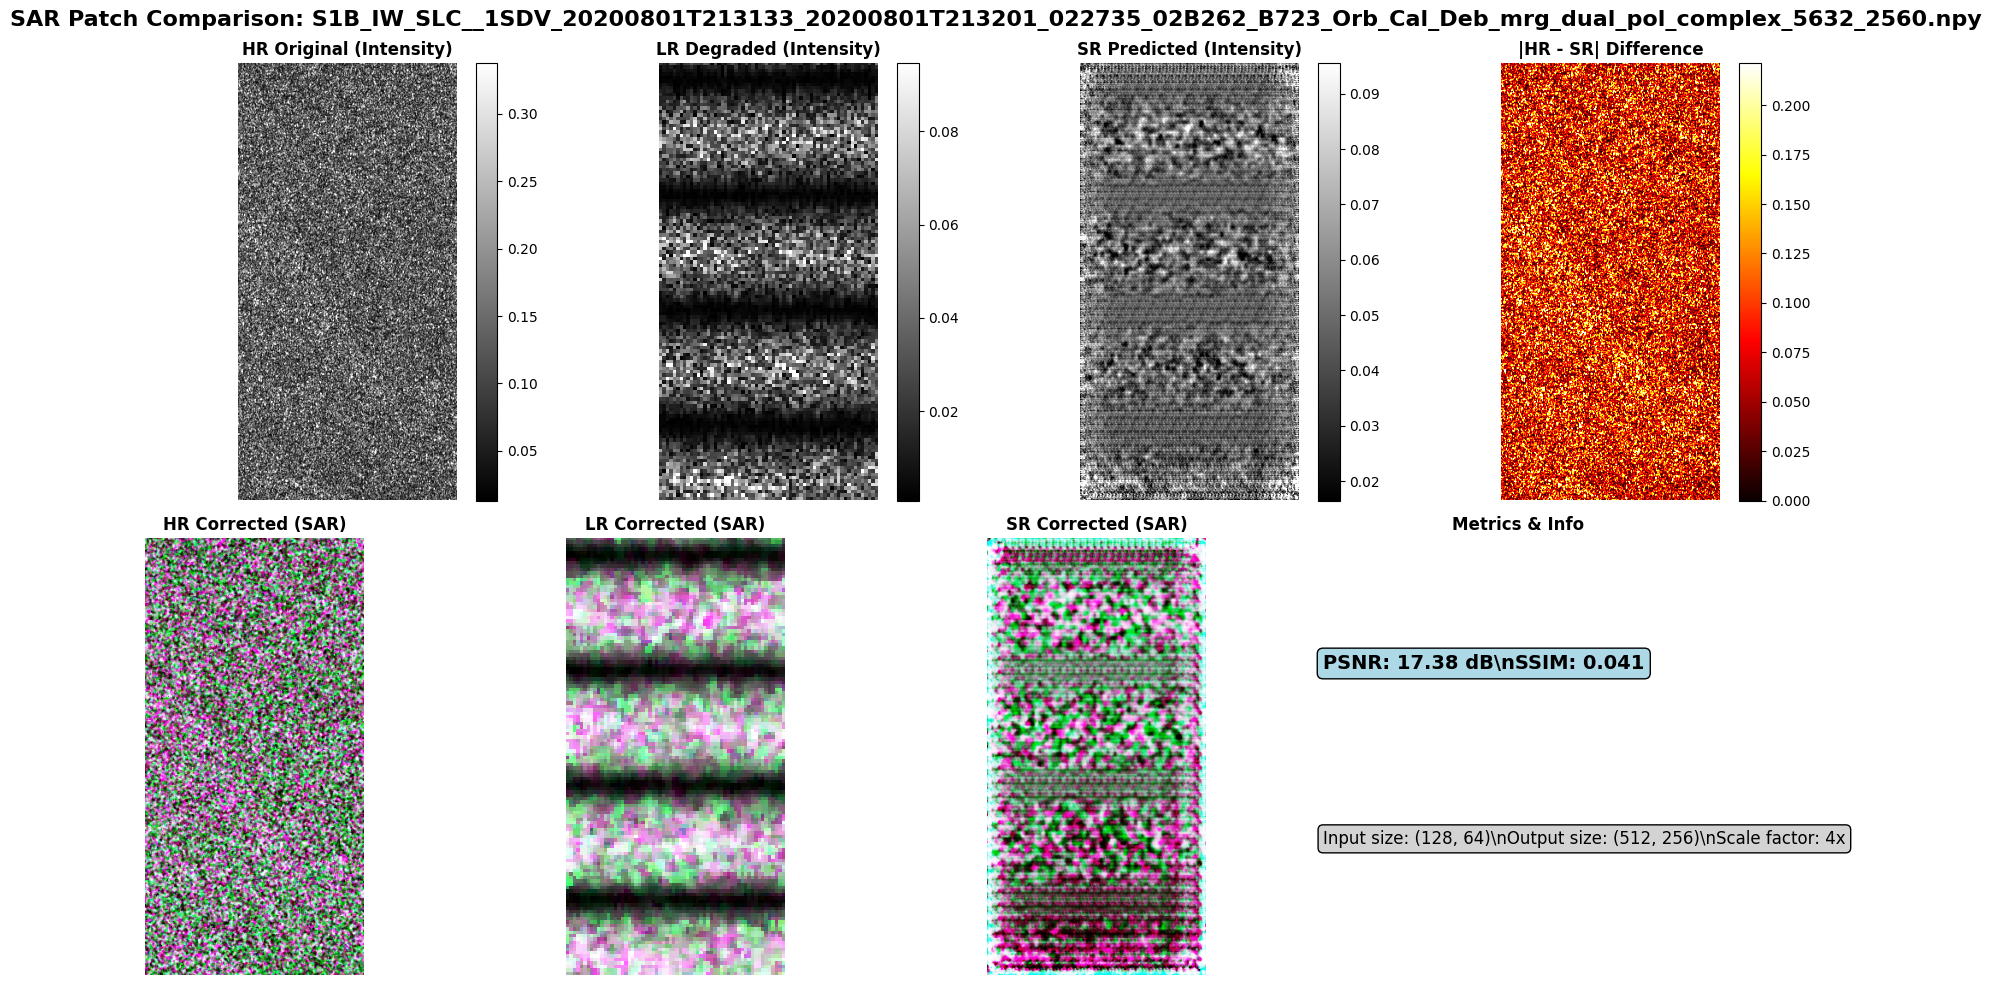

\n--- Creating plot 2/3: S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_43520_7168.npy ---
✓ Saved comparison plot: ../analysis_results\sar_comparison_S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_43520_7168.png
✓ Saved comparison plot: ../analysis_results\sar_comparison_S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_43520_7168.png


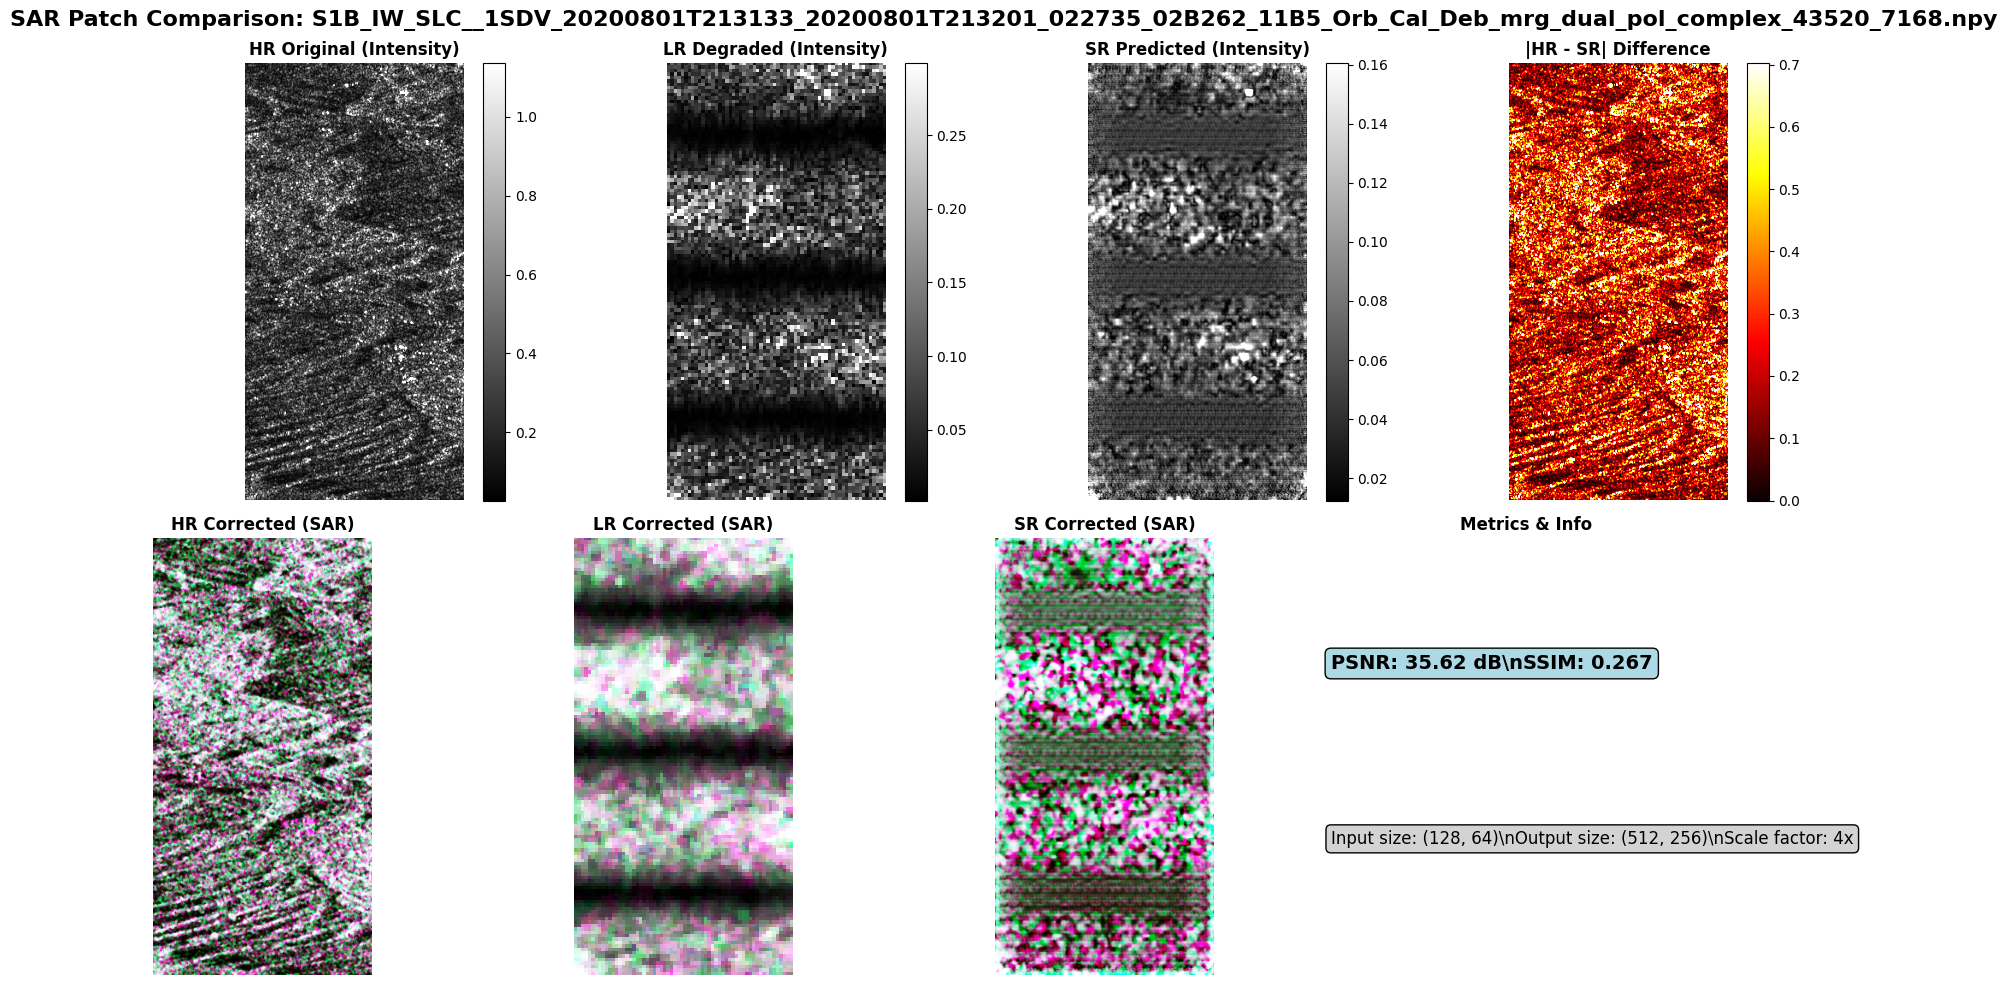

\n--- Creating plot 3/3: S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_17408_7168.npy ---
✓ Saved comparison plot: ../analysis_results\sar_comparison_S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_17408_7168.png
✓ Saved comparison plot: ../analysis_results\sar_comparison_S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_17408_7168.png


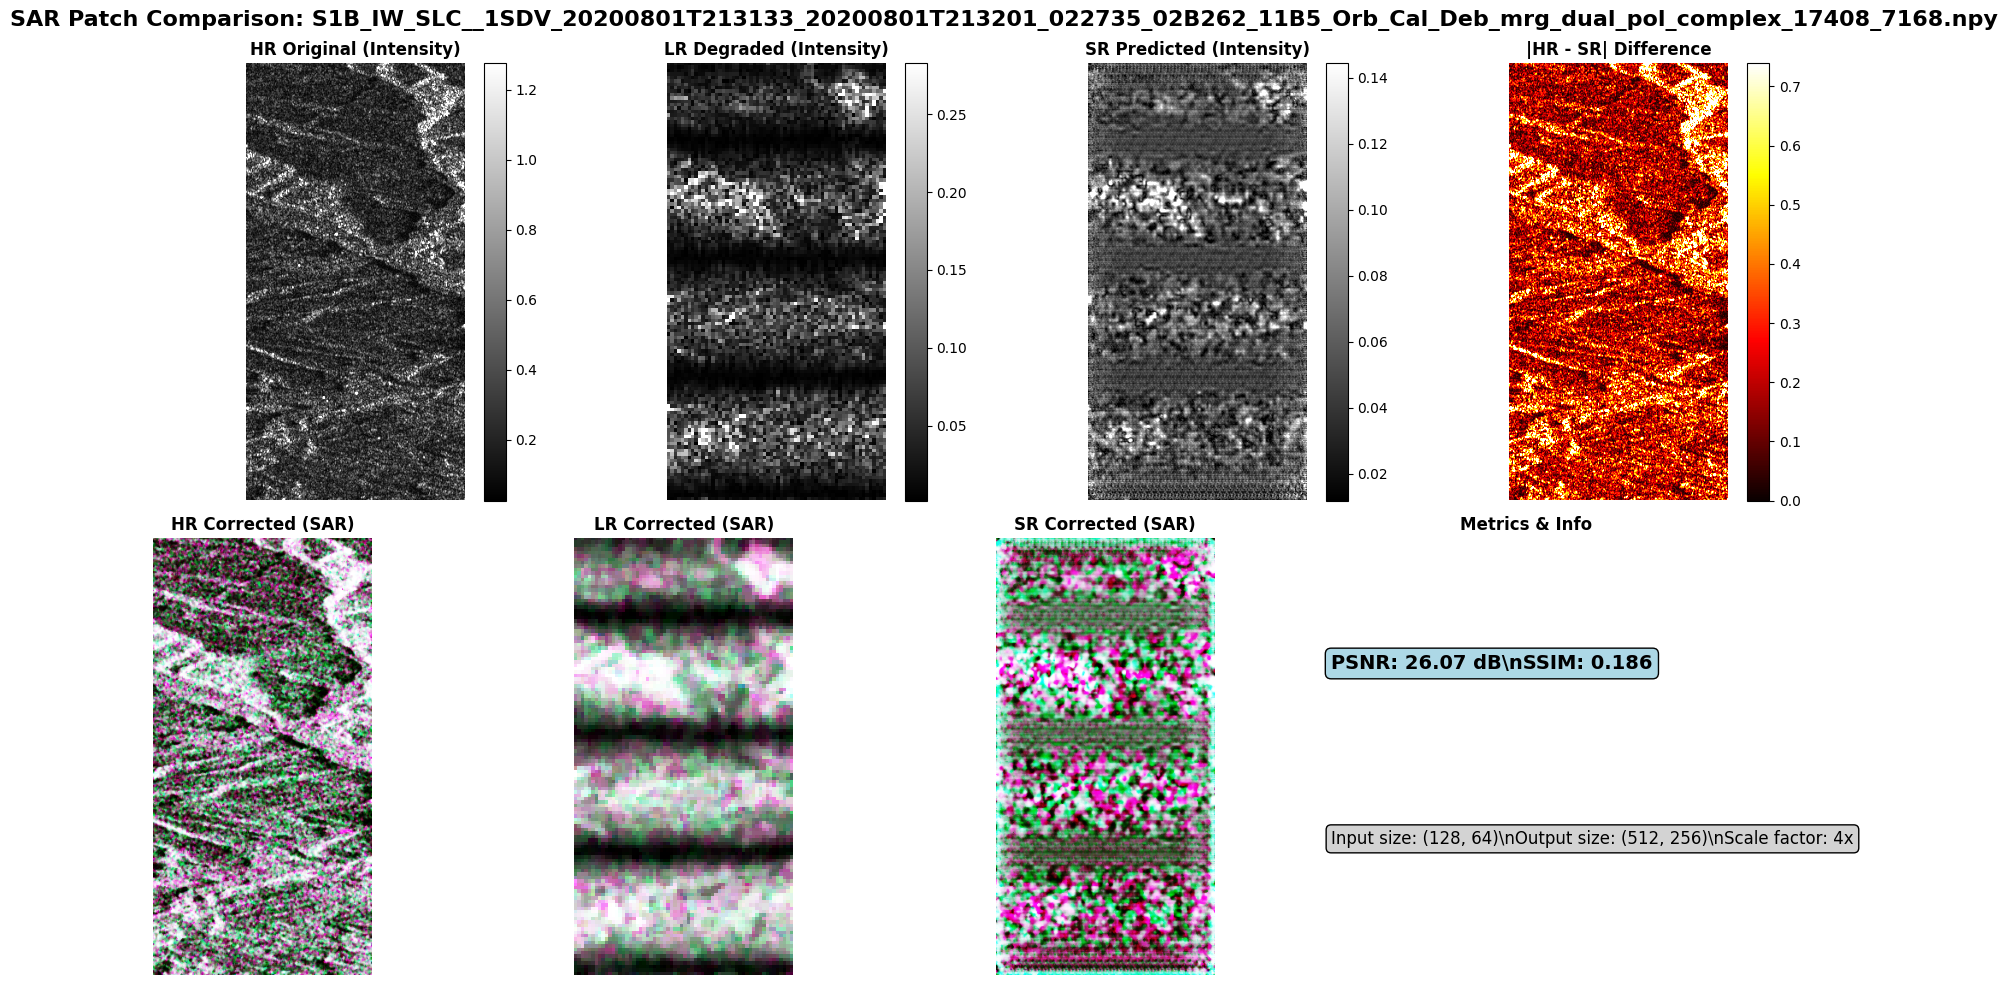

\n✓ All visualizations completed!
Results saved in: ../analysis_results


In [13]:
# 시각화 및 비교 플롯 생성
def create_comparison_plot(result, save_path=None):
    """단일 패치에 대한 비교 플롯 생성"""
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'SAR Patch Comparison: {result["filename"]}', fontsize=16, fontweight='bold')
    
    # 첫 번째 행: 원본 데이터 (복소수 강도)
    hr_intensity = complex_to_intensity(result['hr_original'])
    lr_intensity = complex_to_intensity(result['lr_degraded'])  
    sr_intensity = complex_to_intensity(result['sr_predicted'])
    
    # VV 채널만 표시 (다중채널인 경우)
    if hr_intensity.ndim == 3:
        hr_show = hr_intensity[0]  # VV 채널
        lr_show = lr_intensity[0]  
        sr_show = sr_intensity[0]
    else:
        hr_show = hr_intensity
        lr_show = lr_intensity
        sr_show = sr_intensity
    
    # 첫 번째 행: 강도 이미지
    im1 = axes[0,0].imshow(hr_show, cmap='gray', vmin=np.percentile(hr_show, 1), vmax=np.percentile(hr_show, 99))
    axes[0,0].set_title('HR Original (Intensity)', fontweight='bold')
    axes[0,0].axis('off')
    plt.colorbar(im1, ax=axes[0,0], fraction=0.046, pad=0.04)
    
    im2 = axes[0,1].imshow(lr_show, cmap='gray', vmin=np.percentile(lr_show, 1), vmax=np.percentile(lr_show, 99))
    axes[0,1].set_title('LR Degraded (Intensity)', fontweight='bold')
    axes[0,1].axis('off')
    plt.colorbar(im2, ax=axes[0,1], fraction=0.046, pad=0.04)
    
    im3 = axes[0,2].imshow(sr_show, cmap='gray', vmin=np.percentile(sr_show, 1), vmax=np.percentile(sr_show, 99))
    axes[0,2].set_title('SR Predicted (Intensity)', fontweight='bold')
    axes[0,2].axis('off')
    plt.colorbar(im3, ax=axes[0,2], fraction=0.046, pad=0.04)
    
    # 차이 이미지
    if hr_show.shape == sr_show.shape:
        diff = np.abs(hr_show - sr_show)
        im4 = axes[0,3].imshow(diff, cmap='hot', vmin=0, vmax=np.percentile(diff, 95))
        axes[0,3].set_title('|HR - SR| Difference', fontweight='bold')
        axes[0,3].axis('off')
        plt.colorbar(im4, ax=axes[0,3], fraction=0.046, pad=0.04)
    else:
        axes[0,3].text(0.5, 0.5, 'Size Mismatch', ha='center', va='center', transform=axes[0,3].transAxes)
        axes[0,3].set_title('Difference (N/A)', fontweight='bold')
        axes[0,3].axis('off')
    
    # 두 번째 행: 보정된 SAR 이미지
    hr_corrected = result['hr_corrected']
    lr_corrected = result['lr_corrected']
    sr_corrected = result['sr_corrected']
    
    # 다중채널인 경우 RGB 또는 첫 번째 채널 표시
    if hr_corrected.ndim == 3 and hr_corrected.shape[0] == 3:
        # RGB 이미지로 표시
        hr_vis = np.transpose(hr_corrected, (1, 2, 0))
        lr_vis = np.transpose(lr_corrected, (1, 2, 0))
        sr_vis = np.transpose(sr_corrected, (1, 2, 0))
        cmap_corrected = None
    else:
        # 단일 채널 또는 첫 번째 채널
        hr_vis = hr_corrected[0] if hr_corrected.ndim == 3 else hr_corrected
        lr_vis = lr_corrected[0] if lr_corrected.ndim == 3 else lr_corrected
        sr_vis = sr_corrected[0] if sr_corrected.ndim == 3 else sr_corrected
        cmap_corrected = 'gray'
    
    axes[1,0].imshow(hr_vis, cmap=cmap_corrected)
    axes[1,0].set_title('HR Corrected (SAR)', fontweight='bold')
    axes[1,0].axis('off')
    
    axes[1,1].imshow(lr_vis, cmap=cmap_corrected)
    axes[1,1].set_title('LR Corrected (SAR)', fontweight='bold')  
    axes[1,1].axis('off')
    
    axes[1,2].imshow(sr_vis, cmap=cmap_corrected)
    axes[1,2].set_title('SR Corrected (SAR)', fontweight='bold')
    axes[1,2].axis('off')
    
    # 메트릭 표시
    metrics_text = f"PSNR: {result['metrics']['PSNR']:.2f} dB\\nSSIM: {result['metrics']['SSIM']:.3f}"
    axes[1,3].text(0.1, 0.7, metrics_text, fontsize=14, fontweight='bold', 
                   transform=axes[1,3].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    # 추가 정보
    info_text = f"Input size: {result['lr_degraded'].shape[-2:]}\\nOutput size: {result['sr_predicted'].shape[-2:]}\\nScale factor: {sr_factor}x"
    axes[1,3].text(0.1, 0.3, info_text, fontsize=12, transform=axes[1,3].transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    axes[1,3].set_title('Metrics & Info', fontweight='bold')
    axes[1,3].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved comparison plot: {save_path}")
    
    return fig

# 모든 결과에 대해 시각화 생성
os.makedirs(output_path, exist_ok=True)

print(f"Creating visualization plots for {len(results)} results...")

for i, result in enumerate(results):
    print(f"\\n--- Creating plot {i+1}/{len(results)}: {result['filename']} ---")
    
    if save_results:
        # 파일명에서 확장자 제거하고 비교 플롯 이름 생성
        base_name = os.path.splitext(result['filename'])[0]
        save_path = os.path.join(output_path, f'sar_comparison_{base_name}.png')
    else:
        save_path = None
    
    fig = create_comparison_plot(result, save_path)
    
    # Jupyter에서 표시
    plt.show()
    
    # 메모리 정리
    plt.close(fig)

print(f"\\n✓ All visualizations completed!")
print(f"Results saved in: {output_path}")

\n============================================================
FINAL ANALYSIS
=== SAR Super-Resolution Performance Summary ===
Number of test patches: 3
Model type: swin
Super-resolution factor: 4x

📊 Performance Metrics:
Average PSNR: 26.36 ± 9.12 dB
Average SSIM: 0.165 ± 0.115
Best PSNR: 35.62 dB (S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_43520_7168.npy)
Best SSIM: 0.267 (S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_Cal_Deb_mrg_dual_pol_complex_43520_7168.npy)

📋 Detailed Results:
                                                                                                           Filename  PSNR (dB)     SSIM      HR_Shape     LR_Shape      SR_Shape
 S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_B723_Orb_Cal_Deb_mrg_dual_pol_complex_5632_2560.npy  17.375147 0.041004 (4, 512, 256) (4, 128, 64) (4, 512, 256)
S1B_IW_SLC__1SDV_20200801T213133_20200801T213201_022735_02B262_11B5_Orb_

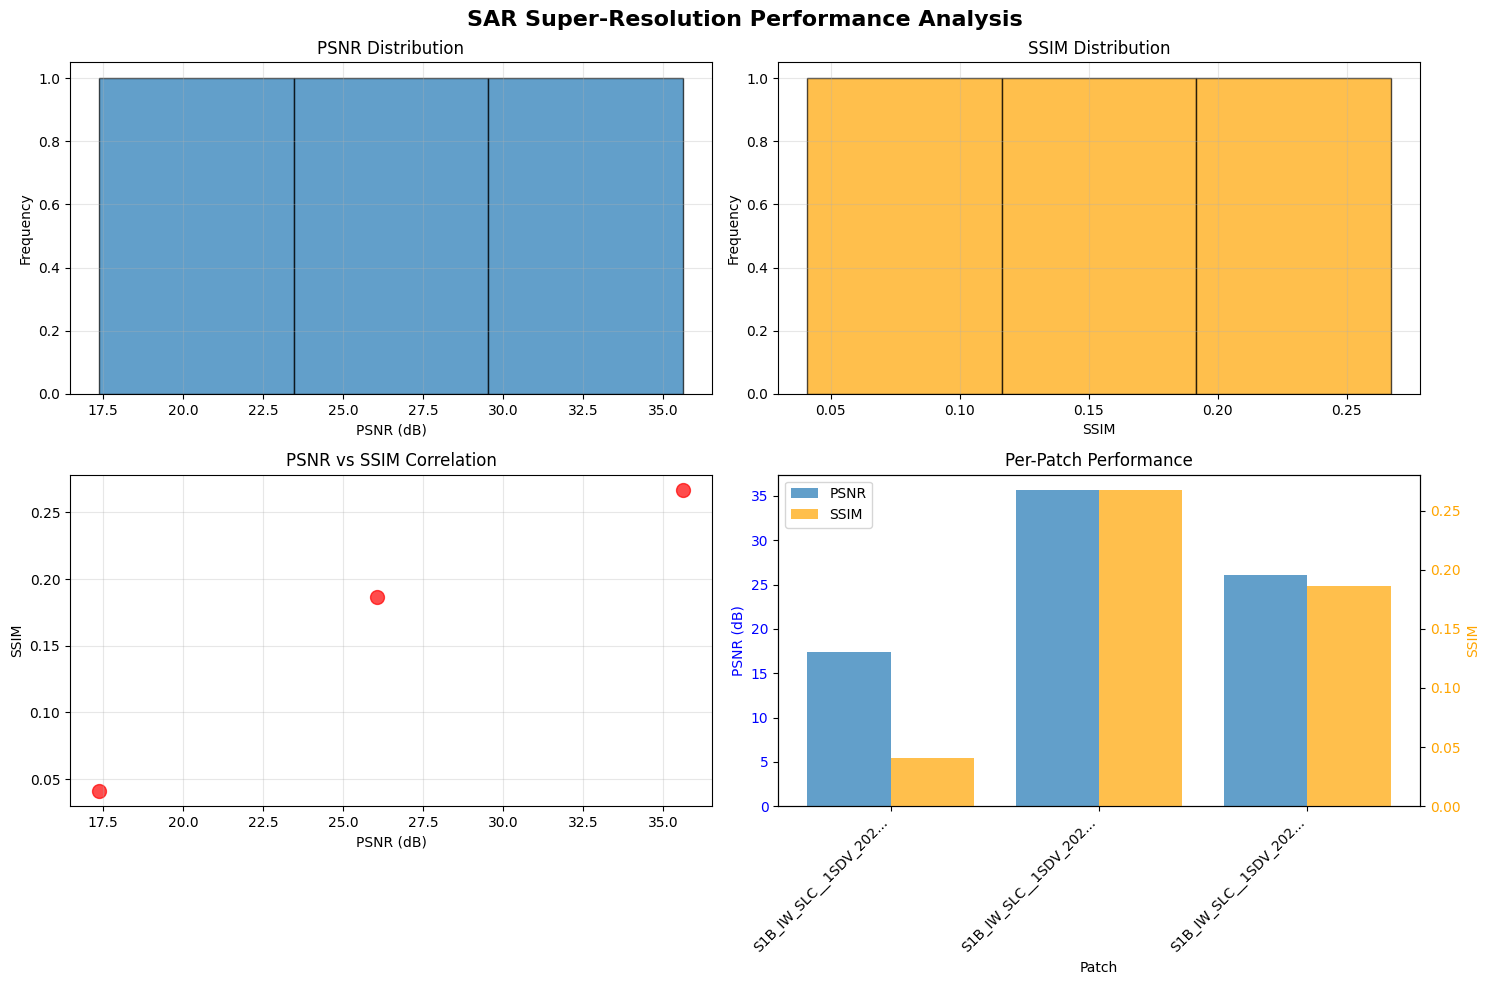

\n✓ Saved metrics to: ../analysis_results\sar_performance_metrics.csv
\n🎉 Analysis complete! Check ../analysis_results for all generated files.


In [14]:
# 요약 통계 및 최종 분석
import pandas as pd

def create_summary_report(results):
    """결과 요약 리포트 생성"""
    
    # 메트릭 데이터 수집
    summary_data = []
    for result in results:
        summary_data.append({
            'Filename': result['filename'],
            'PSNR (dB)': result['metrics']['PSNR'],
            'SSIM': result['metrics']['SSIM'],
            'HR_Shape': str(result['hr_original'].shape),
            'LR_Shape': str(result['lr_degraded'].shape),
            'SR_Shape': str(result['sr_predicted'].shape)
        })
    
    df = pd.DataFrame(summary_data)
    
    # 통계 요약
    print("=== SAR Super-Resolution Performance Summary ===")
    print(f"Number of test patches: {len(results)}")
    print(f"Model type: {model_type}")
    print(f"Super-resolution factor: {sr_factor}x")
    print()
    
    print("📊 Performance Metrics:")
    print(f"Average PSNR: {df['PSNR (dB)'].mean():.2f} ± {df['PSNR (dB)'].std():.2f} dB")
    print(f"Average SSIM: {df['SSIM'].mean():.3f} ± {df['SSIM'].std():.3f}")
    print(f"Best PSNR: {df['PSNR (dB)'].max():.2f} dB ({df.loc[df['PSNR (dB)'].idxmax(), 'Filename']})")
    print(f"Best SSIM: {df['SSIM'].max():.3f} ({df.loc[df['SSIM'].idxmax(), 'Filename']})")
    print()
    
    # 상세 결과 테이블
    print("📋 Detailed Results:")
    print(df.to_string(index=False))
    
    return df

def create_summary_visualization(results):
    """요약 시각화 생성"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('SAR Super-Resolution Performance Analysis', fontsize=16, fontweight='bold')
    
    # PSNR 분포
    psnr_values = [r['metrics']['PSNR'] for r in results]
    axes[0,0].hist(psnr_values, bins=max(3, len(results)//2), alpha=0.7, edgecolor='black')
    axes[0,0].set_title('PSNR Distribution')
    axes[0,0].set_xlabel('PSNR (dB)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].grid(True, alpha=0.3)
    
    # SSIM 분포  
    ssim_values = [r['metrics']['SSIM'] for r in results]
    axes[0,1].hist(ssim_values, bins=max(3, len(results)//2), alpha=0.7, edgecolor='black', color='orange')
    axes[0,1].set_title('SSIM Distribution') 
    axes[0,1].set_xlabel('SSIM')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].grid(True, alpha=0.3)
    
    # PSNR vs SSIM 산점도
    axes[1,0].scatter(psnr_values, ssim_values, alpha=0.7, s=100, c='red')
    axes[1,0].set_title('PSNR vs SSIM Correlation')
    axes[1,0].set_xlabel('PSNR (dB)')
    axes[1,0].set_ylabel('SSIM')
    axes[1,0].grid(True, alpha=0.3)
    
    # 패치별 성능 비교
    patch_names = [r['filename'][:20] + '...' if len(r['filename']) > 20 else r['filename'] for r in results]
    x_pos = np.arange(len(patch_names))
    
    ax1 = axes[1,1]
    bars1 = ax1.bar(x_pos - 0.2, psnr_values, 0.4, label='PSNR', alpha=0.7)
    ax1.set_ylabel('PSNR (dB)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x_pos + 0.2, ssim_values, 0.4, label='SSIM', alpha=0.7, color='orange')
    ax2.set_ylabel('SSIM', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    ax1.set_title('Per-Patch Performance')
    ax1.set_xlabel('Patch')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(patch_names, rotation=45, ha='right')
    
    # 범례
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    
    if save_results:
        summary_plot_path = os.path.join(output_path, 'sar_performance_summary.png')
        plt.savefig(summary_plot_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved summary plot: {summary_plot_path}")
    
    plt.show()
    
    return fig

# 요약 분석 실행
print("\\n" + "="*60)
print("FINAL ANALYSIS")
print("="*60)

# 요약 리포트 생성
df_summary = create_summary_report(results)

# 요약 시각화 생성
summary_fig = create_summary_visualization(results)

# CSV로 결과 저장
if save_results:
    csv_path = os.path.join(output_path, 'sar_performance_metrics.csv')
    df_summary.to_csv(csv_path, index=False)
    print(f"\\n✓ Saved metrics to: {csv_path}")

print(f"\\n🎉 Analysis complete! Check {output_path} for all generated files.")

# 메모리 정리
plt.close('all')